# ApLatamNet Webinar #3 - Inferencia con Dymaxion Labs Platform

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dymaxionlabs/workshops/blob/main/aplatam-net/session3/Inferencia_con_Dymaxion_Labs_Platform.ipynb)

## Preparación

Primero instalamos el SDK de Python de la plataforma. Por el momento hay que instalar una versión prerelease alpha, dado que esta funcionalidad es nuevo y aún estamos desarrollándola, por lo que la interfaz puede sufrir cambios.

In [ ]:
!pip install --pre --ignore-requires-python dymaxionlabs==1.0.0a1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install rasterio scikit-image geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from getpass import getpass

from dymaxionlabs.files import File
from dymaxionlabs.models import Model

Configuramos el API key de la plataforma. Para obtener una API key, es necesario registrarse en la plataforma: https://app.dymaxionlabs.com/

**NOTA**: Por el momento, la funcionalidad de Modelos está sólo habilitada para usuarios Beta. Si queres formar parte de este grupo, te pedimos que te registres [aquí](https://docs.google.com/forms/d/e/1FAIpQLSd0Jx4XMDb7PeDtGRRen3ZBMVTXnVfT0gHeBngLo3NeUNA0mA/viewform).

In [ ]:
os.environ["DYM_API_KEY"] = getpass(prompt="API Key: ")

API Key: ··········


Ahora nos descargamos una imagen de ejemplo sobre la que queremos predecir, y un área de interés.

In [ ]:
!wget https://storage.googleapis.com/dym-workshops-public/aplatam-net/session3/aoi_predict.geojson
!wget https://storage.googleapis.com/dym-workshops-public/aplatam-net/session3/honduras_0000014848-0000000000.tif

--2022-07-20 22:37:28--  https://storage.googleapis.com/dym-workshops-public/aplatam-net/session3/aoi_predict.geojson
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 482 [application/geo+json]
Saving to: ‘aoi_predict.geojson’

aoi_predict.geojson 100%[===================>]     482  --.-KB/s    in 0s      

2022-07-20 22:37:28 (115 MB/s) - ‘aoi_predict.geojson’ saved [482/482]

--2022-07-20 22:37:28--  https://storage.googleapis.com/dym-workshops-public/aplatam-net/session3/honduras_0000014848-0000000000.tif
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 108.177.13.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3685

## 1. Subir imágenes para predecir


In [ ]:
import rasterio
import numpy as np
from skimage.exposure import rescale_intensity
from rasterio.plot import show

In [ ]:
image_path = "./honduras_0000014848-0000000000.tif"
small_image_path = "./honduras_predict.tif"

In [ ]:
!gdalwarp -cutline ./aoi_predict.geojson -crop_to_cutline $image_path $small_image_path

Creating output file that is 465P x 271L.
Processing input file ./honduras_0000014848-0000000000.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


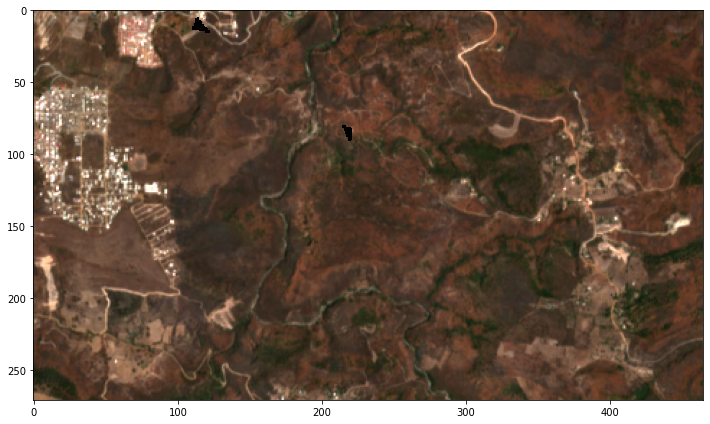

In [ ]:
import matplotlib.pyplot as plt

with rasterio.open(small_image_path) as src:
    rgb_img = np.dstack([src.read(b) for b in range(1, 4)])
    rgb_img = rescale_intensity(rgb_img, in_range=(0, 0.3))
    plt.figure(figsize=(12, 12))
    plt.imshow(rgb_img)

In [ ]:
File.upload(small_image_path, "to_predict/")

In [ ]:
File.all("to_predict/*")

## 2. Obtener modelo ApLatamNet

In [ ]:
model = Model.get("dymaxionlabs/aplatam-net", version="v0.1.1")
model

<Model owner='dymaxionlabs' name='aplatam-net' version='v0.1.1'>

In [ ]:
Model.all("dymaxionlabs")

[<Model owner='dymaxionlabs' name='aplatam-net' version='v0.1.1'>]

In [ ]:
print(model.description)

U-Net based model for mapping informal settlements from Sentinel-2 satellite images.

Images are expected to be Sentinel-2 L2A Surface Reflectance in GeoTiff format, with 4 bands: R, G, B and NIR, respectively.


In [ ]:
model.tags

['unet', 'informal-settlements', 'sentinel-2']

In [ ]:
model.repo_url

'https://github.com/dymaxionlabs/aplatam-net'

## 3. Predecir

In [ ]:
task = model.predict(input_dir="to_predict/",
                     size=160,
                     min_area=1000,
                     threshold=0.5)
task

<dymaxionlabs.tasks.Task id=271 name="ml_models.tasks.predict" state="STARTED">

In [ ]:
task.is_running()

True

In [ ]:
task.wait_until_finished()

In [ ]:
task

## 4. Descargar resultados

In [ ]:
task.has_artifacts()

True

In [ ]:
artifact_path = task.download_artifacts("./output/")

In [ ]:
!unzip -o $artifact_path

Archive:  ./output/artifacts_271.zip
  inflating: output.gpkg             


In [ ]:
import geopandas as gpd

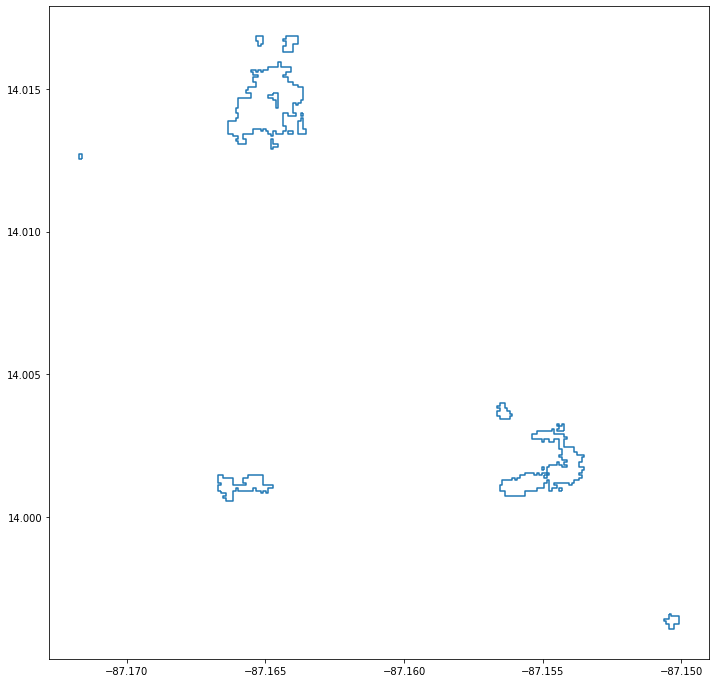

In [ ]:
gdf = gpd.read_file("output.gpkg")
gdf.boundary.plot(figsize=(12, 12))

In [ ]:
gdf